# Первая итерация решения задачи о нахождении контуров кровоизлияния

Необходимые библиотеки

In [289]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydicom
import math
import os
import cv2 as cv
from math import sqrt

Данный код необходим для обработки .dicom файлов, в которых помимо самого МРТ хранится информация об интенсивности пикселей, которые можно удалить из изображения.

In [290]:
train_images_dir = 'images/'

def window_image(img, window_center,window_width, intercept, slope, rescale=True):
    img = (img * slope + intercept)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max        
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def view_image(im):
    data = pydicom.read_file(train_images_dir + 'ID_' + im + '.dcm')
    image = data.pixel_array
    window_center , window_width, intercept, slope = get_windowing(data)                
    image_windowed = window_image(image, window_center, window_width, intercept, slope)                    
    plt.imshow(image_windowed, cmap=plt.cm.bone)       
    plt.axis('off')

Загрузим таблицу с информацией о кровоизлиянии для каждого пациента

In [291]:
train = pd.read_csv('train.csv')
train.head()

ID  Label
0          ID_cb5092a97_epidural      0
1  ID_cb5092a97_intraparenchymal      0
2  ID_cb5092a97_intraventricular      0
3      ID_cb5092a97_subarachnoid      0
4          ID_cb5092a97_subdural      0

Преобразуем таблицу в более читаемый вид

In [292]:
train['Sub_type'] = train['ID'].str.split("_", n = 3, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 3, expand = True)[1]
del train['ID']
train.head()

Label          Sub_type  PatientID
0      0          epidural  cb5092a97
1      0  intraparenchymal  cb5092a97
2      0  intraventricular  cb5092a97
3      0      subarachnoid  cb5092a97
4      0          subdural  cb5092a97

В качестве экспериментального изображения возьмем МРТ пациента с ID bd49667b3. У этого пациента 3 кровоизлияния: интрапаренхиматозное, внутрижелудочковое и субарахноидальное

     Label          Sub_type  PatientID
390      0          epidural  bd49667b3
391      1  intraparenchymal  bd49667b3
392      1  intraventricular  bd49667b3
393      1      subarachnoid  bd49667b3
394      0          subdural  bd49667b3


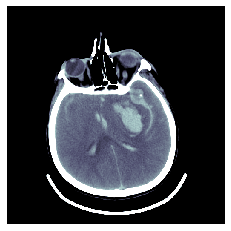

In [293]:
im = 'bd49667b3'
print(train[train['PatientID'] == im].head())
view_image(im)

Сохраним это изображение в формате .png, чтобы потом обрабатывать его с помощь OpenCV.

In [294]:
def save_image_as_png(im):
    data = pydicom.read_file(train_images_dir + 'ID_' + im + '.dcm')
    image = data.pixel_array
    window_center , window_width, intercept, slope = get_windowing(data)

    image_windowed = None
    image_windowed = window_image(image, 40, 80, intercept, slope)
    mpimg.imsave("png_images/" + im + ".png", image_windowed, cmap=plt.cm.bone)
    
save_image_as_png(im)

Загрузим изображение снова и сделаем его черно-белым

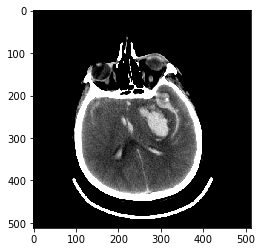

In [295]:
img = cv.cvtColor(cv.imread(im + ".png"), cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

Рассмотрим костные ткани на этом изображении

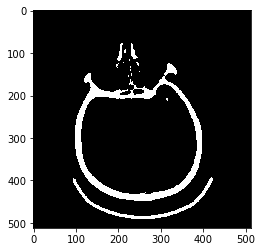

In [296]:
ret, bones = cv.threshold(gray, 244, 255, cv.THRESH_BINARY)
plt.imshow(bones, cmap='gray')

Выделим контур внутренней части черепа (это второй по площади контур на изображении костных тканей)

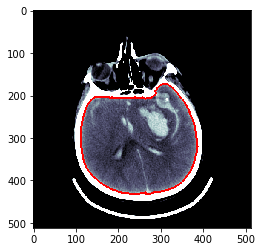

In [297]:
def get_inner_bone_contour(contours):
    sorted_contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)
    return sorted_contours[1]

image, contours, hierarchy = cv.findContours(bones, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
inner_bone = get_inner_bone_contour(contours)
plt.imshow(cv.drawContours(img.copy(), [inner_bone], -1, (255, 0, 0), 3), cmap='bone')

Уберем костные ткани из изображения

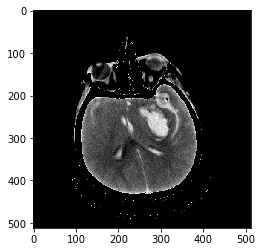

In [298]:
new_img = cv.bitwise_and(gray, gray, mask=cv.bitwise_not(bones))
plt.imshow(new_img, cmap='gray')

Сгладим изображение

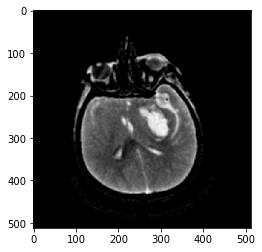

In [299]:
blurred = cv.GaussianBlur(new_img, (5, 5), cv.BORDER_DEFAULT)
plt.imshow(blurred, cmap='gray')

Найдем контуры и удалим с маленькой площадью

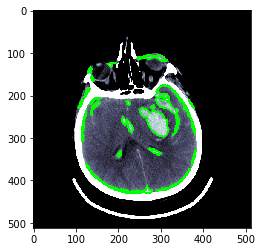

In [300]:
def get_contours_like(contours, func=lambda cnt: True):
    new_contours = []
    for cnt in contours:
        if func(cnt):
            new_contours.append(cnt)
    return new_contours

ret, thresh = cv.threshold(blurred, 127, 255, cv.THRESH_TOZERO)
image, contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = get_contours_like(contours, lambda cnt: cv.contourArea(cnt) > 30)
plt.imshow(cv.drawContours(img.copy(), contours, -1, (0, 255, 0), 3), cmap='bone')

Выберем контуры, которые лежат во внутренней части черепа. Для этого построим описывающую окружность контура inner_bone.

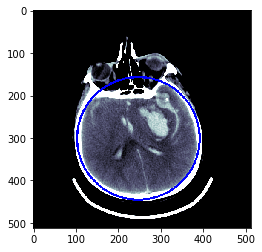

In [301]:
(x,y), radius = cv.minEnclosingCircle(inner_bone)
center = (int(x),int(y))
radius = int(radius)
img_with_circle = img.copy()
plt.imshow(cv.circle(img_with_circle, center, radius, (0, 0, 255), 3), cmap='bone')

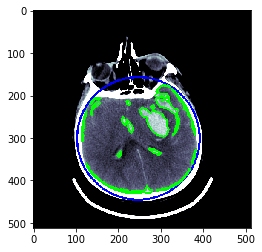

In [302]:
def dist(a, b):
    return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

cnts = []
for c in contours:
    M = cv.moments(c)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    ccenter = (int(cx),int(cy))
    if dist(center, ccenter) < radius:
        cnts.append(c)
        
plt.imshow(cv.drawContours(img_with_circle, cnts, -1, (0, 255, 0), 3), cmap='bone')

Выберем два самых больших  контура по площади

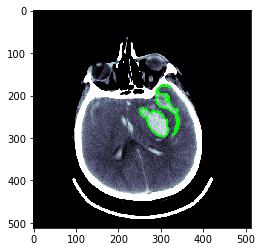

In [303]:
sorted_contours = sorted(cnts, key=lambda x: cv.contourArea(x), reverse=True)
plt.imshow(cv.drawContours(img.copy(), [sorted_contours[0], sorted_contours[1]], -1, (0, 255, 0), 3))

Проведем эти действия со всеми изображениями. Найдем контур с самой большой лощадью, и по этой площади попытаемся сделать предсказание о наличии кровоизлияния.

In [304]:
def get_area(im):
    img = cv.cvtColor(cv.imread(im), cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    # Remove bones
    ret, thresh = cv.threshold(gray, 244, 255, cv.THRESH_BINARY)
    image, contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    if len(contours) < 2: # invalid image, no inner_bone part
        return 0
    inner_circle = get_inner_bone_contour(contours)
    new_image = cv.bitwise_and(gray, gray, mask=cv.bitwise_not(thresh))
    
    # Draw contours
    new_image = cv.GaussianBlur(new_image, (5, 5), cv.BORDER_DEFAULT)
    ret, thresh = cv.threshold(new_image, 127, 255, cv.THRESH_TOZERO)
    image, contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = get_contours_like(contours, lambda cnt: cv.contourArea(cnt) > 20)
    
    (x,y), radius = cv.minEnclosingCircle(inner_circle)
    center = (int(x),int(y))
    radius = int(radius)
    if len(contours) > 16: # smashed head
        return 0
    cnts = []
    for c in contours:
        (cx, cy), cradius = cv.minEnclosingCircle(c)
        ccenter = (int(cx),int(cy))
        if dist(center, ccenter) < radius:
            cnts.append(c)
    if len(cnts) > 12 or len(cnts) == 0: # smashed head
        return 0
    sorted_contours = sorted(cnts, key=lambda x: cv.contourArea(x), reverse=True)
    if cv.arcLength(sorted_contours[0], True) > 0.6 * cv.arcLength(inner_circle, True):
        return 0
    return cv.contourArea(sorted_contours[0])

Найденные площади для МРТ без кровоизлияний

c:\users\810200\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(array([2.443e+03, 6.900e+01, 4.000e+01, 1.700e+01, 4.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([   0. ,  475.1,  950.2, 1425.3, 1900.4, 2375.5, 2850.6, 3325.7,
        3800.8, 4275.9, 4751. ]),
 <a list of 10 Patch objects>)

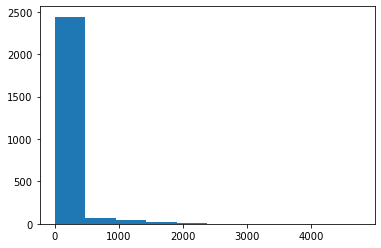

In [305]:
p = []
any_0 = train[train['Sub_type'] == 'any'][train['Label'] == 0]
for index, row in any_0.iterrows():    
    a = get_area("png_images/" + row["PatientID"] + ".png")
    p.append(a)
plt.hist(p)

Найденные площади для МРТ с кровоизлиянием

c:\users\810200\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(array([356.,  25.,  13.,  10.,   7.,   5.,   2.,   1.,   0.,   2.]),
 array([   0. ,  359.2,  718.4, 1077.6, 1436.8, 1796. , 2155.2, 2514.4,
        2873.6, 3232.8, 3592. ]),
 <a list of 10 Patch objects>)

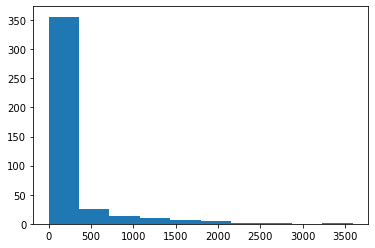

In [306]:
p1 = []
any_1 = train[train['Sub_type'] == 'any'][train['Label'] == 1]
for index, row in any_1.iterrows():
    a = get_area("png_images/" + row["PatientID"] + ".png")
    p1.append(a)
plt.hist(p1)

Итоговая точность

In [307]:
cnt = 0
for i in p:
    if i == 0:
        cnt += 1
cnt1 = 0
for i in p1:
    if i != 0:
        cnt1 += 1
print((cnt + cnt1) / (len(p) + len(p1)))

0.685
